[View in Colaboratory](https://colab.research.google.com/github/yepuv1/primality/blob/master/primality_nn.ipynb)

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import sympy 
from tensorflow.python.framework import ops
from sympy import primerange, sieve, composite, prime
import pickle
import timeit
%matplotlib inline
np.random.seed(1)

In [3]:
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.11.0
Found GPU at: /device:GPU:0


In [0]:
PRIMES_FILENAME = "10million_primes.p"
def save_primes(file):
  p_num = [i for i in primerange(2, 100000000)]
  pickle.dump( p_num, open(file, "wb" ))
  return p_num

def load_primes(file):
 return pickle.load(open(file, "rb" ))

PRIMES = save_primes(PRIMES_FILENAME)

In [0]:
def convert_dec2bin(num_list,feature_size):
  p_x = None
  for p in num_list:
    pb = bin(p)[2:].zfill(32)
    li = [ int(i) for i in pb]
    a1 = np.array(li).reshape((feature_size,1))
    if p_x is None:
      p_x = a1
    else:
      p_x = np.concatenate((p_x, a1), axis=1)
  return p_x

In [0]:
def generate_sequence_primes(between):
  start, end = between
  p_num = [i for i in primerange(start, end)]
  return p_num, len(p_num)

In [0]:
def generate_random_primes(size, primes):
  le = len(primes)
  p_num = [primes[i] for i in np.random.randint(le , size=size)]
  return p_num, size

In [0]:
def generate_composite(size):
  c_num = np.random.randint(10000000, size=size)
  return c_num, size
  

In [0]:
def generate_x_y(primes, composites=None, feature_size=32):
  
  only_primes = False
  if composites is None:
    only_primes = True
  
  p_examples_size = len(primes)
  p_x = convert_dec2bin(primes, feature_size)
  p_y = np.ones(shape=(1,p_examples_size), dtype=np.int32)
  
  X = None
  Y = None
  
  if not only_primes:
    c_examples_size = len(composites)
    c_x = convert_dec2bin(composites, feature_size)
    c_y = np.zeros(shape=(1,c_examples_size), dtype=np.int32)
    X = np.concatenate((c_x, p_x), axis=1)
    Y = np.append(c_y, p_y).reshape((1, 2*examples_size))
    size = p_examples_size + c_examples_size
  else:
    X = p_x
    Y = p_y
    size = p_examples_size
    
  return X, Y, size
  

In [0]:
examples_size = 20
c, size = generate_composite(examples_size)
p, size = generate_random_primes(examples_size,PRIMES)
X, Y, examples_size = generate_x_y(p,c)

In [0]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(dtype=tf.int32, name="C", value=C)
    one_hot_matrix = tf.one_hot(labels,depth=C, axis=0)
    with tf.Session() as sess:
      one_hot = sess.run(one_hot_matrix)
   
    return one_hot


In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of input vector 
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))

    
    return X, Y

In [0]:
def initialize_parameters(dic_of_layer_sizes):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 2]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1) 
        
    
    parameters ={}
    for key, value in dic_of_layer_sizes.items():
      print(key)
      print(value)
      parameters[key]=tf.get_variable(key, value, initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR ->  SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
              
    Z1 = tf.add(tf.matmul(W1, X), b1)  # LINEAR                                         
    A1 = tf.nn.relu(Z1)                # RELU                           
    Z2 = tf.add(tf.matmul(W2, A1), b2) # LINEAR                                           

    return Z2

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def model(X_train, Y_train, X_test, Y_test,dic_of_layer_sizes,learning_rate = 0.0001,
          num_epochs = 1024, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    dic_of_layer_sizes - dictionary of W<n> b<n> sizes as [x,y]
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    with tf.device('/gpu:0'):

      ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
      tf.set_random_seed(1)                             # to keep consistent results
      seed = 3                                          # to keep consistent results
      (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
      n_y = Y_train.shape[0]                            # n_y : output size
      costs = []                                        # To keep track of the cost

      # Create Placeholders of shape (n_x, n_y)
      X, Y = create_placeholders(n_x, n_y)

      # Initialize parameters
      parameters = initialize_parameters(dic_of_layer_sizes)

      # Forward propagation: Build the forward propagation in the tensorflow graph
      Z3 = forward_propagation(X=X, parameters=parameters)

      # Cost function: Add cost function to tensorflow graph
      cost = compute_cost(Y=Y,Z3=Z3)

      # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


      # Initialize all the variables
      init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config=config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [0]:
%%time
examples_size = 50000
c, size = generate_composite(examples_size)
p, size = generate_random_primes(examples_size,PRIMES)
X_train, Y_train, training_size = generate_x_y(p,c)

examples_size = 100
c, size = generate_composite(examples_size)
p, size = generate_random_primes(examples_size,PRIMES)
X_test, Y_test, test_size = generate_x_y(p,c)

Y_train = one_hot_matrix(Y_train.reshape(training_size), 2)
Y_test = one_hot_matrix(Y_test.reshape(test_size), 2)


print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

dic_of_layer_sizes ={
    "W1":[5,32],
    "b1":[5,1],
    "W2":[2,5],
    "b2":[2,1]
}

parameters = model(
    X_train, 
    Y_train, 
    X_test, 
    Y_test, 
    dic_of_layer_sizes, 
    num_epochs=1000,
    minibatch_size=64
)

number of training examples = 100000
number of test examples = 200
X_train shape: (32, 100000)
Y_train shape: (2, 100000)
X_test shape: (32, 200)
Y_test shape: (2, 200)
W1
[5, 32]
b1
[5, 1]
W2
[2, 5]
b2
[2, 1]
Cost after epoch 0: 0.673102
Cost after epoch 100: 0.165589
Cost after epoch 200: 0.157435
Cost after epoch 300: 0.155511
Cost after epoch 400: 0.154598


In [0]:
pickle.dump( parameters, open('parameters.par', "wb" ))

(32, 10000)
Accuracy: 0.88
(32, 15000)
Accuracy: 0.8792667
(32, 20000)
Accuracy: 0.87925
(32, 25000)
Accuracy: 0.88156
(32, 30000)
Accuracy: 0.8791
(32, 35000)
Accuracy: 0.88097143
(32, 40000)
Accuracy: 0.87905
(32, 45000)
Accuracy: 0.88015556


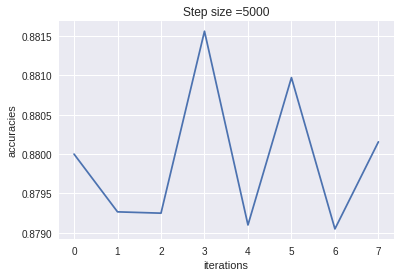

CPU times: user 2min 32s, sys: 5.63 s, total: 2min 37s
Wall time: 2min 37s


In [25]:
%%time
start = 10000
end = 50000
step_size = 5000

accuracies = []
for p_size in range(start, end, step_size):
  p, size = generate_random_primes(p_size, PRIMES)
  X, Y, size = generate_x_y(p,None)
  print(X.shape)
  Y = one_hot_matrix(Y.reshape(size), 2)
  init = tf.global_variables_initializer()
  with tf.Session() as session:
    session.run(init)
    z3 = forward_propagation(np.float32(X), parameters)
    p = tf.argmax(z3)
    res = session.run(p)

    # Calculate the correct predictions
    correct_prediction = tf.equal(res, tf.argmax(Y))
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracies.append(accuracy.eval())
    print ("Accuracy:", accuracy.eval())

# plot the cost
plt.plot(np.squeeze(accuracies))
plt.ylabel('accuracies')
plt.xlabel('iterations')
plt.title("Step size =" + str(step_size))
plt.show()


(32, 10000)
Accuracy: 0.8827
(32, 15000)
Accuracy: 0.8774667
(32, 20000)
Accuracy: 0.8808
(32, 25000)
Accuracy: 0.88208
(32, 30000)
Accuracy: 0.8816
(32, 35000)
Accuracy: 0.8772857
(32, 40000)
Accuracy: 0.88135
(32, 45000)
Accuracy: 0.8793333


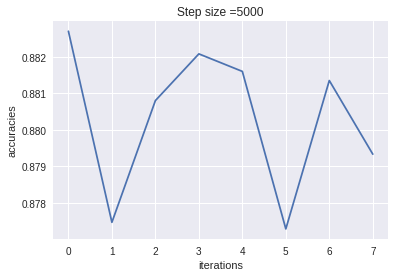

CPU times: user 2min 34s, sys: 6.08 s, total: 2min 40s
Wall time: 2min 40s


In [26]:
%%time
start = 10000
end = 50000
step_size = 5000

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
accuracies = []
with tf.device('/gpu:0'):
  for p_size in range(start, end, step_size):
    p, size = generate_random_primes(p_size, PRIMES)
    X, Y, size = generate_x_y(p,None)
    print(X.shape)
    Y = one_hot_matrix(Y.reshape(size), 2)
    init = tf.global_variables_initializer()
    with tf.Session(config=config) as session:
      session.run(init)
      z3 = forward_propagation(np.float32(X), parameters)
      p = tf.argmax(z3)
      res = session.run(p)

      # Calculate the correct predictions
      correct_prediction = tf.equal(res, tf.argmax(Y))
      # Calculate accuracy on the test set
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
      accuracies.append(accuracy.eval())
      print ("Accuracy:", accuracy.eval())

# plot the cost
plt.plot(np.squeeze(accuracies))
plt.ylabel('accuracies')
plt.xlabel('iterations')
plt.title("Step size =" + str(step_size))
plt.show()

